In [1]:
## Session from https://www.youtube.com/watch?v=PaCmpygFfXo

In [2]:
from __future__ import annotations
import numpy as np
from tqdm import tqdm, trange
import math

from itertools import product, count
from functools import reduce
import operator

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

In [3]:
dataset_path = '/tmp/data.txt'

In [4]:
! curl https://raw.githubusercontent.com/karpathy/makemore/master/names.txt > {dataset_path}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  222k  100  222k    0     0   504k      0 --:--:-- --:--:-- --:--:--  504k


In [5]:
with open(dataset_path, 'rt') as fp:
    xs = [x.strip() for x in fp]
    
all_chars = sorted(set(''.join(xs)))
len(all_chars) # should be 26

26

In [6]:
SPECIAL_DELIM = '!'

# <string> to <integer> and reverse mappings
stoi = {s: i for i, s in enumerate(all_chars, start=1)}
stoi[SPECIAL_DELIM] = 0

itos = {i: s for s, i in stoi.items()}

In [7]:
def train_bigrams(words: list[str], stoi: dict[str, int]) -> np.ndarray:
    mat = np.zeros((len(stoi),) * 2, dtype=np.int32)
    
    for word in tqdm(words, desc='Training bigrams'):
        xs = [SPECIAL_DELIM, *word, SPECIAL_DELIM]
        
        for a, b in zip(xs[:-1], xs[1:]):
            mat[stoi[a], stoi[b]] += 1
            
    return mat

In [8]:
mat = train_bigrams(words=xs, stoi=stoi)

Training bigrams: 100%|████████████████████████████████████████████████████████████████| 32033/32033 [00:00<00:00, 96220.22it/s]


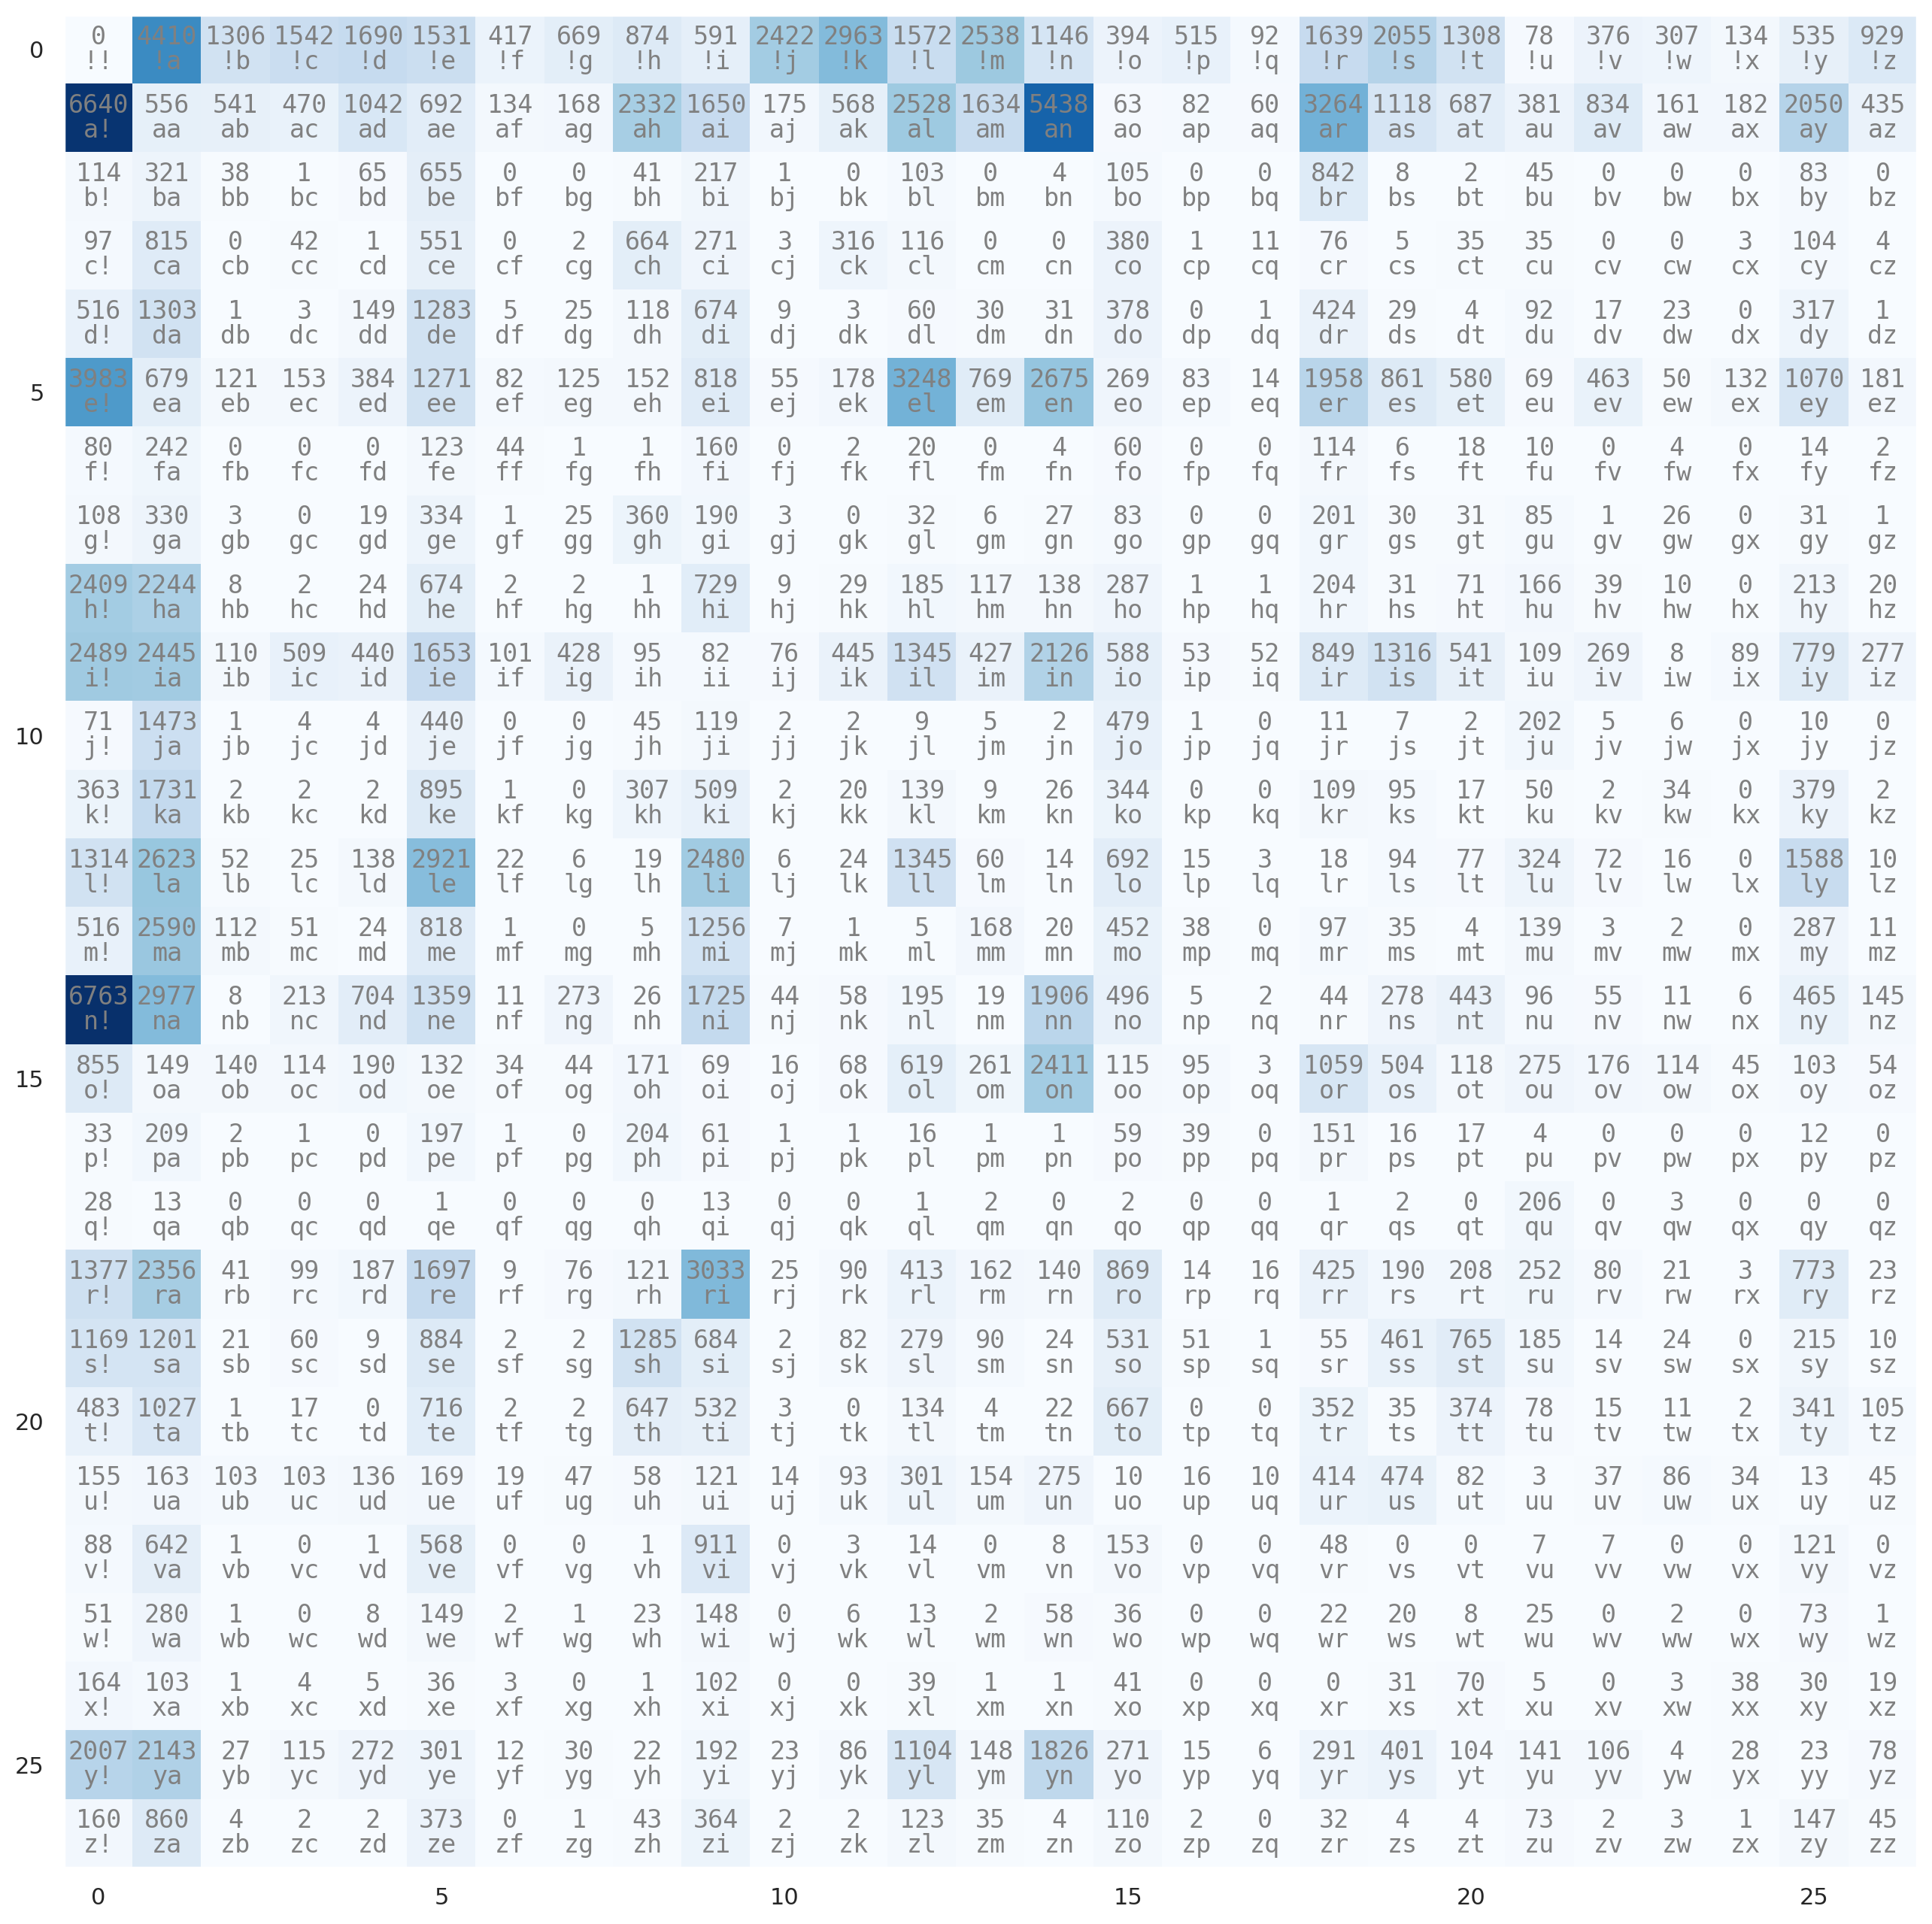

In [9]:
plt.figure(figsize=(16,)*2)
plt.imshow(mat, cmap='Blues')
plt.grid(False)

kwargs = dict(ha='center', color='gray', fontfamily='monospace')

for i, j in product(range(len(stoi)), repeat=2):
    plt.text(j, i, (itos[i] + itos[j]), va='top', **kwargs)
    plt.text(j, i, mat[i, j], va='bottom', **kwargs)

In [10]:
def sample_one(prob_mat: np.ndarray, itos: dict[int, str], rng: "Generator") -> str:
    # start from the beginning (SPECIAL_DELIM)
    ix = 0 
    word = SPECIAL_DELIM
    
    while True:
        ix = rng.choice(np.arange(len(prob_mat)), size=1, p=prob_mat[ix]).item()
        word += itos[ix]
        if ix == 0:
            break
        
    return word[1:-1] # strip SPECIAL_DELIM

def sample_many(sample_one: callable, num: int) -> list[str]:
    if num == 0:
        return
    yield sample_one()
    yield from sample_many(sample_one, num - 1)

In [11]:
rng = np.random.default_rng(seed=4242)

In [12]:
prob_mat = mat.copy().astype(np.float32)
# prob_mat = np.ones_like(mat, dtype=np.float32)

prob_mat = prob_mat / prob_mat.sum(axis=1, keepdims=True)
assert np.allclose(np.ones(27), prob_mat.sum(1))

In [13]:
words = sample_many(lambda: sample_one(prob_mat, itos, rng), 10)
list(words)

['ria',
 'gah',
 'kweriliysoavieavieyn',
 'h',
 'guna',
 'diulalonannisah',
 'zanloician',
 'hatinstohanarijam',
 'ais',
 'k']

In [14]:
def search_for_word(word: str, sample_one: callable, timeout: int = 10_000):
    for i in trange(timeout, ascii=True, disable=True):
        if (x := sample_one()) == word:
            return i + 1
    return None

In [15]:
def word_proba(word: str, prob_mat: np.ndarray, stoi: dict[str, int]) -> float:
    xs = [stoi[c] for c in word]
    return reduce(
        operator.mul, 
        map(lambda i, j: prob_mat[i, j], [0, *xs], [*xs, 0])
    )

def word_nll(word: str, prob_mat: np.ndarray, stoi: dict[str, int]) -> float:
    xs = [stoi[c] for c in word]
    return sum(map(lambda i, j: -np.log(prob_mat[i, j]), [0, *xs], [*xs, 0]))

In [16]:
word = 'alex'
p = word_proba(word, prob_mat, stoi)
print(f'steps("{word}"):', 'inf' if p == 0 else f'{math.ceil(1/p):,d}')

steps("alex"): 305,926


In [17]:
with open(dataset_path, 'rt') as fp:
    words = [x.strip() for x in fp]
    
n = 0
log_prob = 0
for word in words:
    xs = [stoi[c] for c in word]
    for i, j in zip([0, *xs], [*xs, 0]):
        n += 1
        log_prob += np.log(prob_mat[i, j])
        
-log_prob/n

2.454014495314936

## NN

In [18]:
import torch as T
import torch.nn.functional as F

In [19]:
# DATASET CONSTRUCTION

with open(dataset_path, 'rt') as fp:
    words = [x.strip() for x in fp]
    
xs, ys = [], []

for word in words:
    cs = [stoi[s] for s in (SPECIAL_DELIM, *word, SPECIAL_DELIM)]
    xs.extend(cs[:-1])
    ys.extend(cs[1:])
    
xs, ys = map(T.tensor, (xs, ys))
NUM_EXAMPLES = len(xs)
NUM_EXAMPLES

228146

In [20]:
# INIT
lr = 75
epochs = 200
g = T.Generator().manual_seed(4211)

# network weights: one layer, 27 inputs, 27 outputs
W = T.randn(27, 27, dtype=T.float32, requires_grad=True, generator=g)
# W = T.rand(27, 27, dtype=T.float32, requires_grad=True, generator=g)

# we're using the entire data for one epoch
for epoch in range(1, epochs + 1):
    # FORWARD PASS

    xenc = F.one_hot(xs, num_classes=27).float()
    logits = (xenc @ W) # log-count

    # softmax
    counts = logits.exp()
    probs  = counts / counts.sum(1, keepdims=True)

    # regularization
    # keeping the weights close to 0
    # has the effect of keeping the count close to 1
    # which in turn makes the dist. "more uniform"
    # => smoothing
    reg = (W**2).mean()
    
    loss = -probs[T.arange(NUM_EXAMPLES), ys].log().mean() + 0.05 * reg
    print(f"{epoch=:3d} | {loss=:.6f}", end='\r')
    
    # BACKWARD PASS
    W.grad = None # resetting the gradients
    loss.backward()
    
    # UPDATE
    W.data += -lr * W.grad

In [21]:
def nn_sample_one():
    with T.no_grad():
        ix = 0 
        word = SPECIAL_DELIM

        while True:
            x = T.zeros(1, 27, dtype=T.float32)
            x[0, ix] = 1.0

            logits = (x @ W)
            counts = logits.exp()
            probs  = counts / counts.sum(1, keepdims=True)

            ix = T.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
            word += itos[ix]

            if ix == 0:
                break

    return word[1:-1]
    
[nn_sample_one() for _ in range(10)]

['nthlauseittya',
 'mynqbontonini',
 'arinaca',
 'm',
 'per',
 'toto',
 'joviuwn',
 'zs',
 'an',
 'bdeiyn']

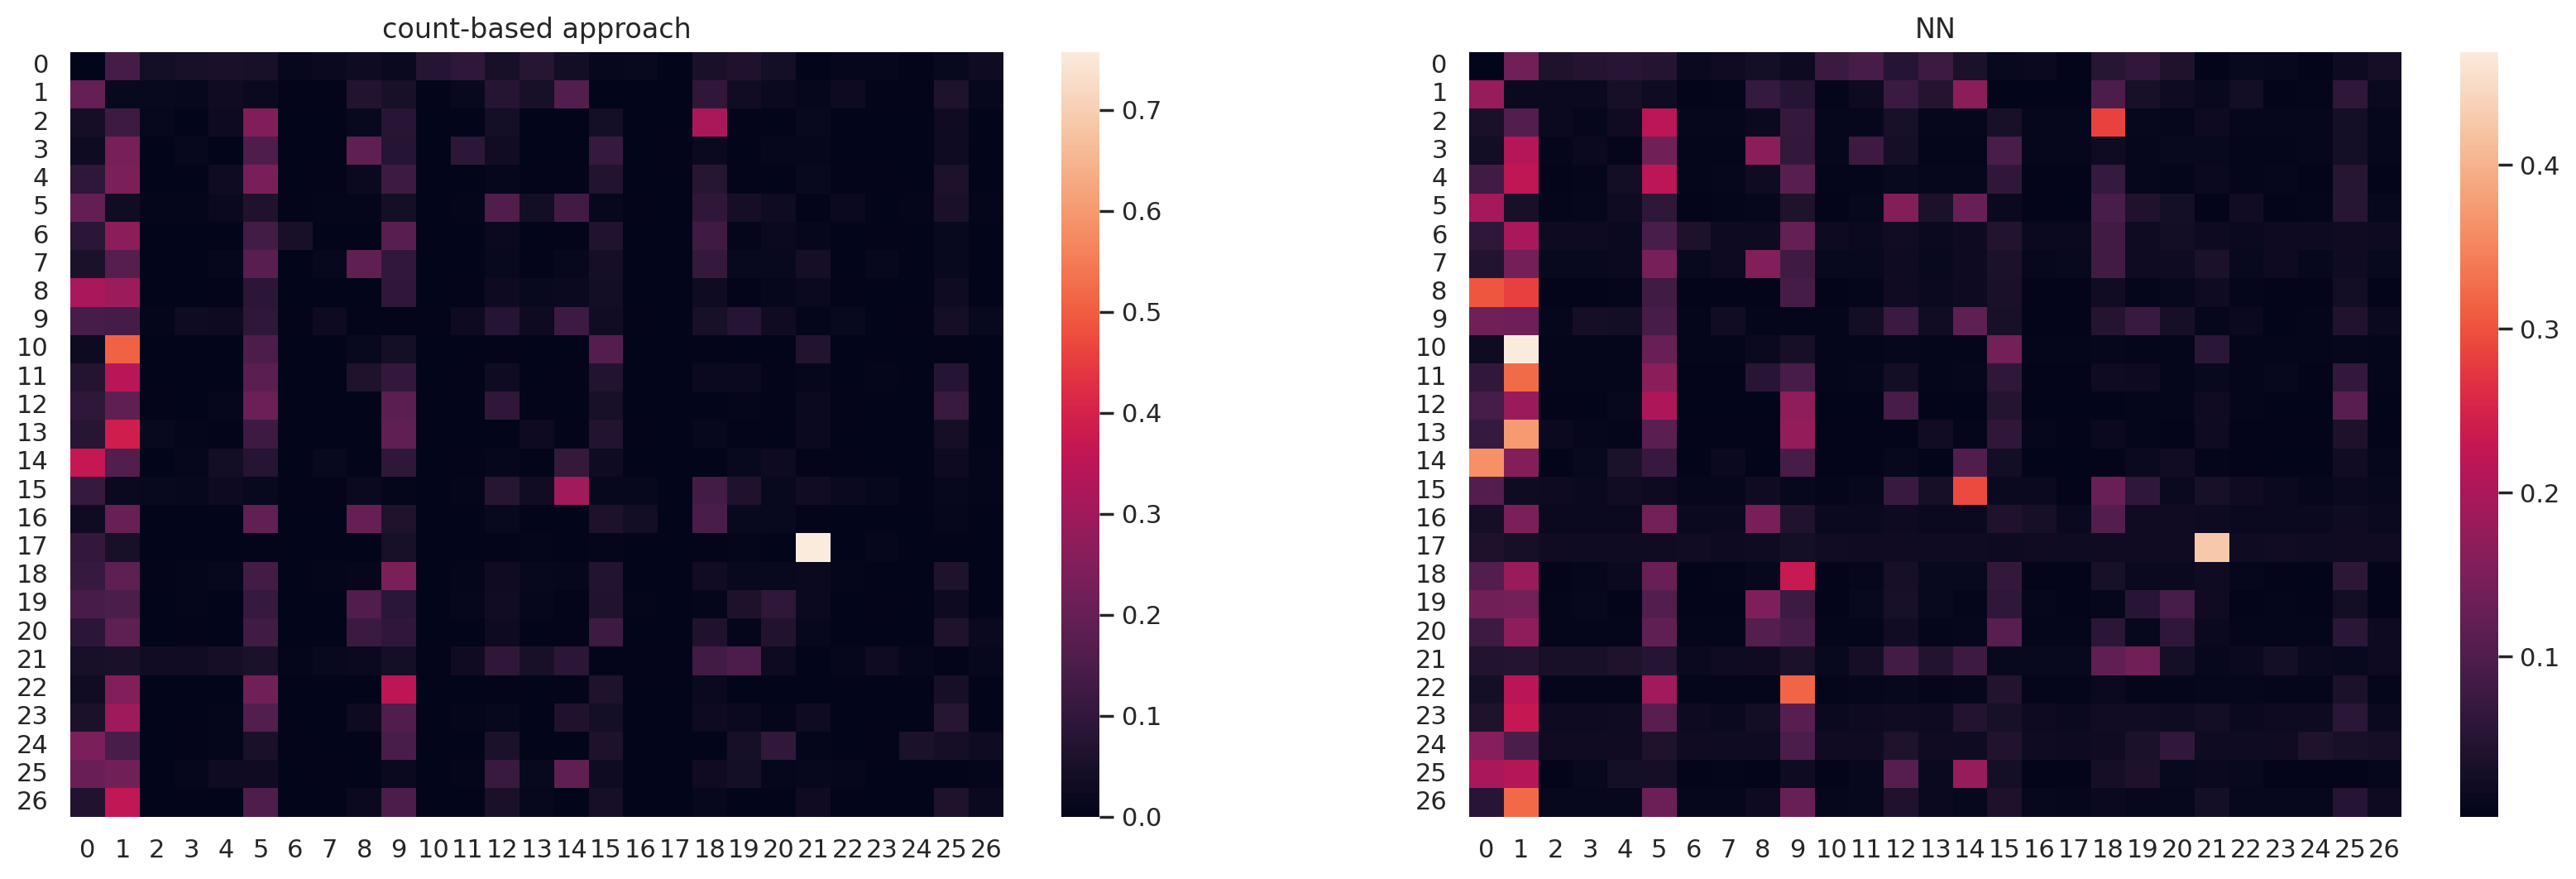

In [22]:
# notice that we arrive at very similar results compared to the count-based approach

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
sns.heatmap(prob_mat)
plt.title('count-based approach')

plt.subplot(1, 2, 2)
with T.no_grad():
    nn_prob_mat = F.softmax(W, dim=1)
    sns.heatmap(nn_prob_mat)
plt.title('NN')

pass